# **Fake News Classifier**
By: **John Manuel Carado** from **BSCS 2-A** of WVSU

Dataset Link: [Fake News Dataset Link](https://www.kaggle.com/datasets/iamrahulthorat/fakenews-csv)

In [1]:
# Necessary Imports
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
%matplotlib inline

## Exploratory Data Analysis

In [2]:
fake_news = pd.read_csv('./fakenews.csv')

In [3]:
fake_news.head()

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0


In [4]:
# Getting the length of the messages
fake_news['word_count'] = fake_news['text'].apply(len)

<AxesSubplot: xlabel='word_count', ylabel='Count'>

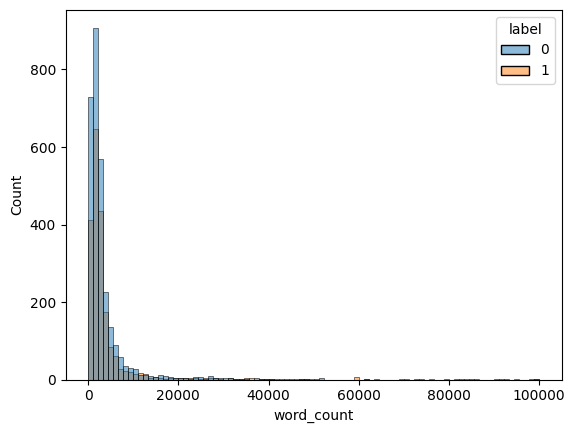

In [5]:
# Plotting the distribution of word count for each label
sns.histplot(data=fake_news, x='word_count', bins=90, hue='label')

As we can see from the histogram, majority of news reports are very well below 20,000 words. And a few outliers that news reports are over 40,000 words.

<AxesSubplot: xlabel='label', ylabel='word_count'>

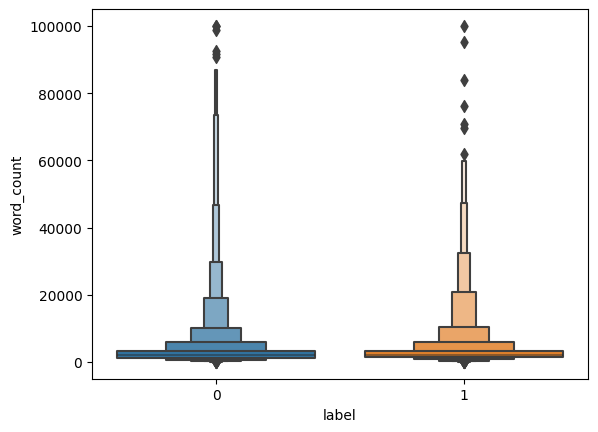

In [6]:
sns.boxenplot(data=fake_news, x='label', y='word_count')

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

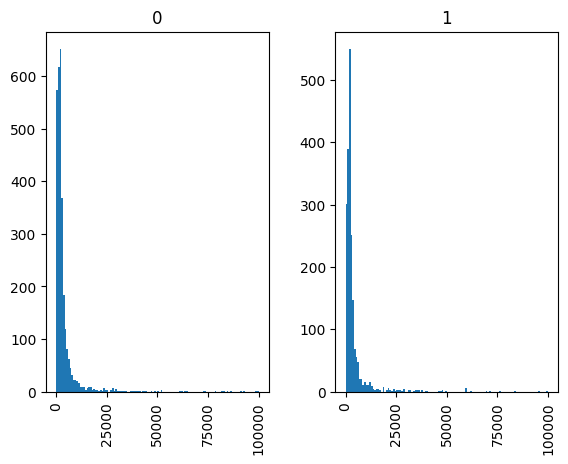

In [7]:
fake_news.hist(column='word_count', by='label', bins=120)

In [8]:
print(f"fake: {fake_news[fake_news['label'] == 1]['word_count'].std()}\nrealnews: {fake_news[fake_news['label'] == 0]['word_count'].std()}")

fake: 7627.965862571352
realnews: 8045.414123581585


<AxesSubplot: xlabel='word_count', ylabel='Count'>

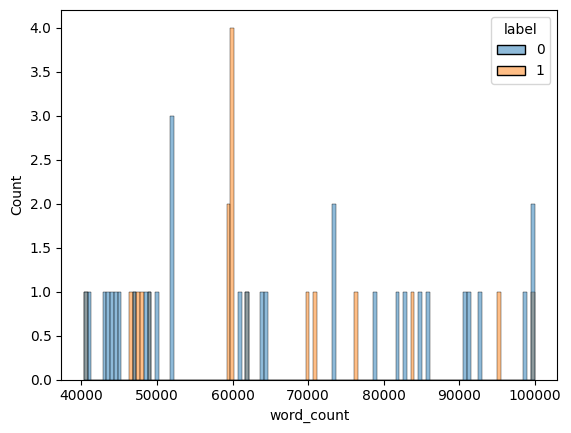

In [36]:
# Dropping news reports that are above 40k word count
fake_news_40k_words = fake_news[fake_news['word_count'] > 40000]
sns.histplot(data=fake_news_40k_words, x='word_count', bins=120, hue='label')

In [37]:
# Dropping outliers
print(fake_news.shape)
fake_news = fake_news[fake_news['word_count'] < 40000]
print(fake_news.shape)

(4986, 3)
(4936, 3)


## Text Preprocessing

In [9]:
# Import text preprocessing libraries
import string
from nltk.corpus import stopwords

In [25]:
# Tokenization of text (removal of punctuations, and stopwords)
def clean_text(text):
    _nopunc = [c for c in text if c not in string.punctuation]
    _nopunc = ''.join(_nopunc)
    clean = []
    for word in _nopunc.split():
        if word.lower() not in stopwords.words('english'):
            clean.append(word)
    return clean

In [29]:
print(f"Original Text: {fake_news['text'][1]}\nPreprocessed Text: {clean_text(fake_news['text'][1])}")

Original Text: 2d  Conan On The Funeral Trump Will Be Invited To - CONAN on TBS
Preprocessed Text: ['2d', 'Conan', 'Funeral', 'Trump', 'Invited', 'CONAN', 'TBS']


## Vectorization, and Training

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [52]:
X, y = fake_news['text'], fake_news['label']

In [53]:
# Creating a sparse matrix of the text column
X = CountVectorizer(analyzer=clean_text).fit_transform(X)

In [62]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=101)

In [64]:
classifier = MultinomialNB()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       862
           1       0.73      0.73      0.73       619

    accuracy                           0.77      1481
   macro avg       0.77      0.77      0.77      1481
weighted avg       0.77      0.77      0.77      1481



<AxesSubplot: >

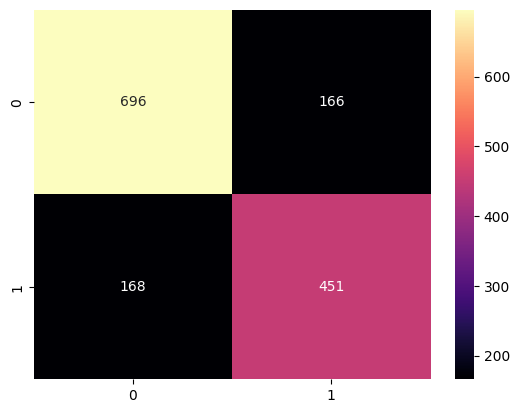

In [71]:
print(classification_report(y_test, y_pred))
sns.heatmap(data=confusion_matrix(y_test, y_pred), cmap='magma', fmt='d', annot=True)

## Training with TF-IDF

In [74]:
tf_transformer = TfidfTransformer().fit(X)

In [75]:
x2 = tf_transformer.transform(X)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.3, random_state=101)

In [84]:
classifier = MultinomialNB()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       862
           1       0.94      0.24      0.38       619

    accuracy                           0.68      1481
   macro avg       0.79      0.62      0.58      1481
weighted avg       0.77      0.68      0.61      1481



<AxesSubplot: >

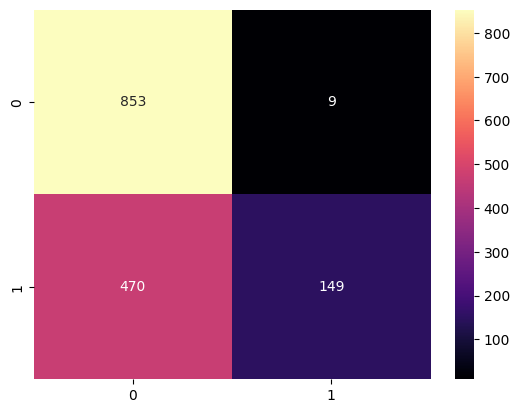

In [85]:
print(classification_report(y_test, y_pred))
sns.heatmap(data=confusion_matrix(y_test, y_pred), cmap='magma', fmt='d', annot=True)

## KFold Validation

In [88]:
from sklearn.model_selection import cross_val_score, KFold

In [91]:
# No Tf-idf
classifier = MultinomialNB()
cv_scores = cross_val_score(classifier, X, y, cv=KFold(n_splits=7, shuffle=True, random_state=101))
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation scores: [0.79149798 0.7854251  0.77935223 0.78947368 0.77935223 0.77935223
 0.77484787 0.79716024 0.76673428 0.76673428]
Mean accuracy: 0.7809930114723539


In [93]:
# With Tf-idf
classifier = MultinomialNB()
cv_scores = cross_val_score(classifier, x2, y, cv=KFold(n_splits=7, shuffle=True, random_state=101))
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation scores: [0.70113314 0.6893617  0.70921986 0.7106383  0.70496454 0.6964539
 0.7035461 ]
Mean accuracy: 0.7021882202341487
